In [50]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal
from sklearn.pipeline import Pipeline
from pprint import pprint
from datetime import datetime

In [51]:
# Select file to analyze
stave_supine_static = "../Data/1_Stave_supine_static.txt"
mattress_supine = "../Data/2_Mattress_supine.txt"
subject_sitting_chair = "../Data/3_Subject_sitting_chair.txt"
chest_sweater = "../Data/4_Chest_sweater.txt"
under_chair = "../Data/5_Under_chair.txt"
center_sternum = "../Data/center_sternum.txt"

#### IMPORT DATA-SET AND CALIBRATION

In [81]:
# Import the file inside "raw_data" Dataframe
data = pd.read_csv(center_sternum, sep='\t').reset_index(drop=True)
data.head()

,Log Mode,Log Freq,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,5,200,1576222772,947.086,435.662,70.638,-6.824428,-14.244280,1.404580,-454,-490,-178,0.792622,0.254952,-0.553850,-0.000031
1,5,200,1576222772,969.168,387.777,88.877,6.183206,-12.290080,-7.969466,-454,-490,-177,0.736461,0.275124,-0.617969,0.006806
2,5,200,1576222772,989.603,380.335,78.751,11.709920,-4.961832,-7.450382,-454,-490,-177,0.729465,0.275246,-0.626118,0.009827
3,5,200,1576222772,954.894,418.033,88.328,17.877860,2.519084,-5.984733,-454,-492,-176,0.723413,0.277200,-0.632221,0.011383
4,5,200,1576222772,972.096,427.732,99.857,25.221370,5.404580,4.015267,-454,-492,-176,0.721948,0.280007,-0.632679,0.010193


In [82]:
# Define Calibration variables from file
offset_gyro = np.array([-2.242224, 2.963463, -0.718397])

calibration_acc = np.array([[ 1.0009660000, -0.002326418, -0.0006995499],
                            [-0.0023263790,  0.978704500, -0.0015409180],
                            [-0.0006995811, -0.001540928,  1.0040300000]])

offset_acc = np.array([-3.929942, -13.746790, 60.675460])

calibration_magn = np.array([[ 0.919285100, -0.023251680, 0.003480837],
                             [-0.023251750,  0.914876000, 0.004257396],
                             [ 0.003481006,  0.004257583, 0.874800100]])

offset_magn = np.array([-95.679740, -244.914200, 17.711320])

# Apply calibration and offset to respective columns
data[['GyroX', 'GyroY', 'GyroZ']] += offset_gyro
data[['AccX', 'AccY', 'AccZ']] = np.dot(data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc
data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn

#### SAMPLE RATE ANALYSIS

In [83]:
# Cofronting the nominal frequency given in the coloumn with the one we can get from timestamps
couts = data.groupby(["Log Freq"]).count().value_counts()
frequency = data.loc[0, "Log Freq"]
print("The nominal frequency in the Log column is", frequency)

t_min = datetime.fromtimestamp(data["Timestamp"].min())  
t_max = datetime.fromtimestamp(data["Timestamp"].max())  
acquisition_seconds = (t_max-t_min).total_seconds()      
acq_per_sec = data.groupby("Timestamp").size()
mean_frequency = np.mean(acq_per_sec)  


print("The starting time for the acquisition is: ", t_min)
print("The ending time for the acquisition is: ", t_max)
print("The total time of acquisition is: ", acquisition_seconds, "s")

print("\nThe total number of acquisitions is: ",data.shape[0])
print("The mean sampling frequency is: ", round(mean_frequency, 3))

percentage_difference = np.abs(frequency - mean_frequency) / frequency * 100
print("The difference in percentage from the nominal frequency to the mean frequency from time stamps is", round(percentage_difference, 2),"%")

The nominal frequency in the Log column is 200
The starting time for the acquisition is:  2019-12-13 08:39:32
The ending time for the acquisition is:  2019-12-13 08:40:47
The total time of acquisition is:  75.0 s

The total number of acquisitions is:  16506
The mean sampling frequency is:  217.184
The difference in percentage from the nominal frequency to the mean frequency from time stamps is 8.59 %


Since the difference in percentage from the nominal frequency and the one computed from timestamps we wonder if the frequency is actually constant during the acquisition.

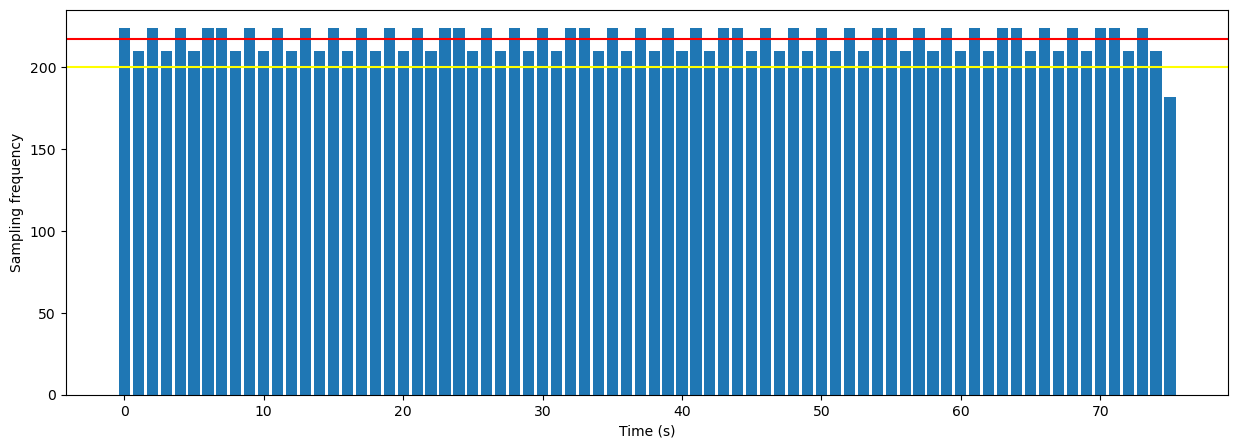

In [84]:
unique_timestamp_counts = data["Timestamp"].value_counts()
num_unique_timestamps = len(unique_timestamp_counts)

fig, ax = plt.subplots(figsize=(15,5))
ax.bar(np.arange(num_unique_timestamps), acq_per_sec)
ax.axhline(mean_frequency, color="red", label="Mean frequency")
ax.axhline(200, color="yellow", label="Nominal frequency")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Sampling frequency");

We see from te plot that the sampling frequency isn't the same on all seconds

In [85]:
# we also see that in total we have 16492 rows, so we insert a coloumn with time
data.insert(2, "Time", np.arange(0, data.shape[0]) * (1 / mean_frequency), allow_duplicates=False)

#### PLOTTING THE DATA

In [86]:
# define the column groups
column_groups = {
    "Accelerometer": ["AccX", "AccY", "AccZ"],
    "Gyroscope": ["GyroX", "GyroY", "GyroZ"],
    "Magnetometer": ["MagnX", "MagnY", "MagnZ"],
    "Quaternion": ["qw", "qi", "qj", "qk"]
}


In [87]:
def plot(data, column_groups):
    """ Function to plot the data divided in sub-groups """
    # create subplots for each group
    fig, axs = plt.subplots(len(column_groups), 1, figsize=(15, 10), sharex=False)

    # iterate through column groups and plot all columns in the same graph for each group
    for i, (group_name, columns) in enumerate(column_groups.items()):
        data.plot(ax=axs[i], x="Time", y=columns, title=group_name)
        axs[i].set_ylabel(group_name)

    # set common x-axis label
    axs[-1].set_xlabel("Time")

    # adjust layout for better readability
    plt.tight_layout()




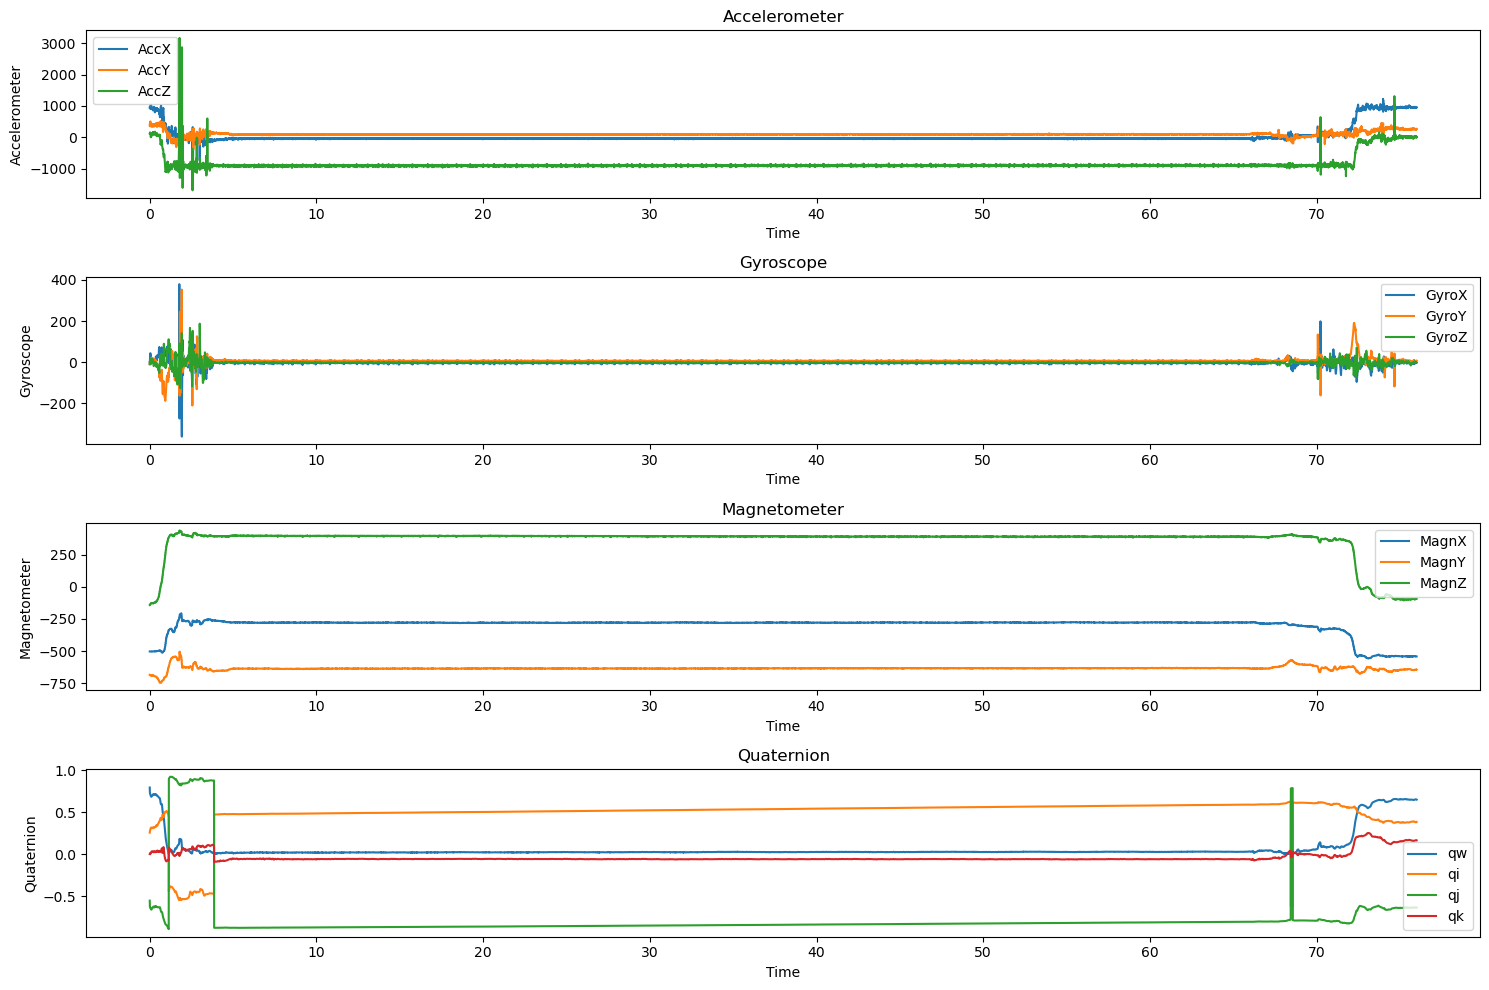

In [88]:
plot(data, column_groups)

We see that at the beginning and at the end of the data set there is a lot of noise, we need to clean the data-set: to do so we only the central rows of the data-frame, where the bounds of it are determined using a method called IQR 

#### CLEANING THE DATA

In [89]:
# Function to clean the data  (DEPRECATED)
def clean_data(data, column_groups):
    # Create a new DataFrame for cleaned data
    clean_data = data.copy()

    # Iterate through column groups and filter the data
    for group_name, columns in column_groups.items():
        for column in columns:
            # Calculate the IQR for each column
            Q1 = clean_data[column].quantile(0.25)
            Q3 = clean_data[column].quantile(0.75)
            IQR = Q3 - Q1

            # Identify and remove outliers based on the IQR
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]

    return clean_data


In [90]:
# Cutting the start and the end of the dataset

cleaned_data = data[1129:14306].reset_index(drop=True)
cleaned_data.tail()

,Log Mode,Log Freq,Time,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
13172,5,200,65.847328,1576222837,-40.415614,99.972112,-887.560833,-5.112453,6.413845,-2.000840,-277.221820,-632.524980,388.684933,0.027717,0.588855,-0.805475,-0.060762
13173,5,200,65.851933,1576222837,-37.419900,100.033601,-893.258880,-5.234590,6.368043,-2.077176,-277.221820,-632.524980,388.684933,0.027129,0.588885,-0.805475,-0.060732
13174,5,200,65.856537,1576222837,-43.790755,104.743776,-879.604047,-4.944514,6.627585,-2.031374,-276.302534,-632.548232,388.688414,0.027724,0.588916,-0.805414,-0.060976
13175,5,200,65.861141,1576222837,-42.203581,104.259188,-877.460801,-4.990316,6.932929,-2.199313,-276.302534,-632.548232,388.688414,0.027626,0.588946,-0.805383,-0.061129
13176,5,200,65.865746,1576222837,-30.279899,105.949765,-907.849686,-4.669705,7.238272,-2.443588,-277.228781,-632.533495,386.935333,0.027930,0.588977,-0.805353,-0.061098


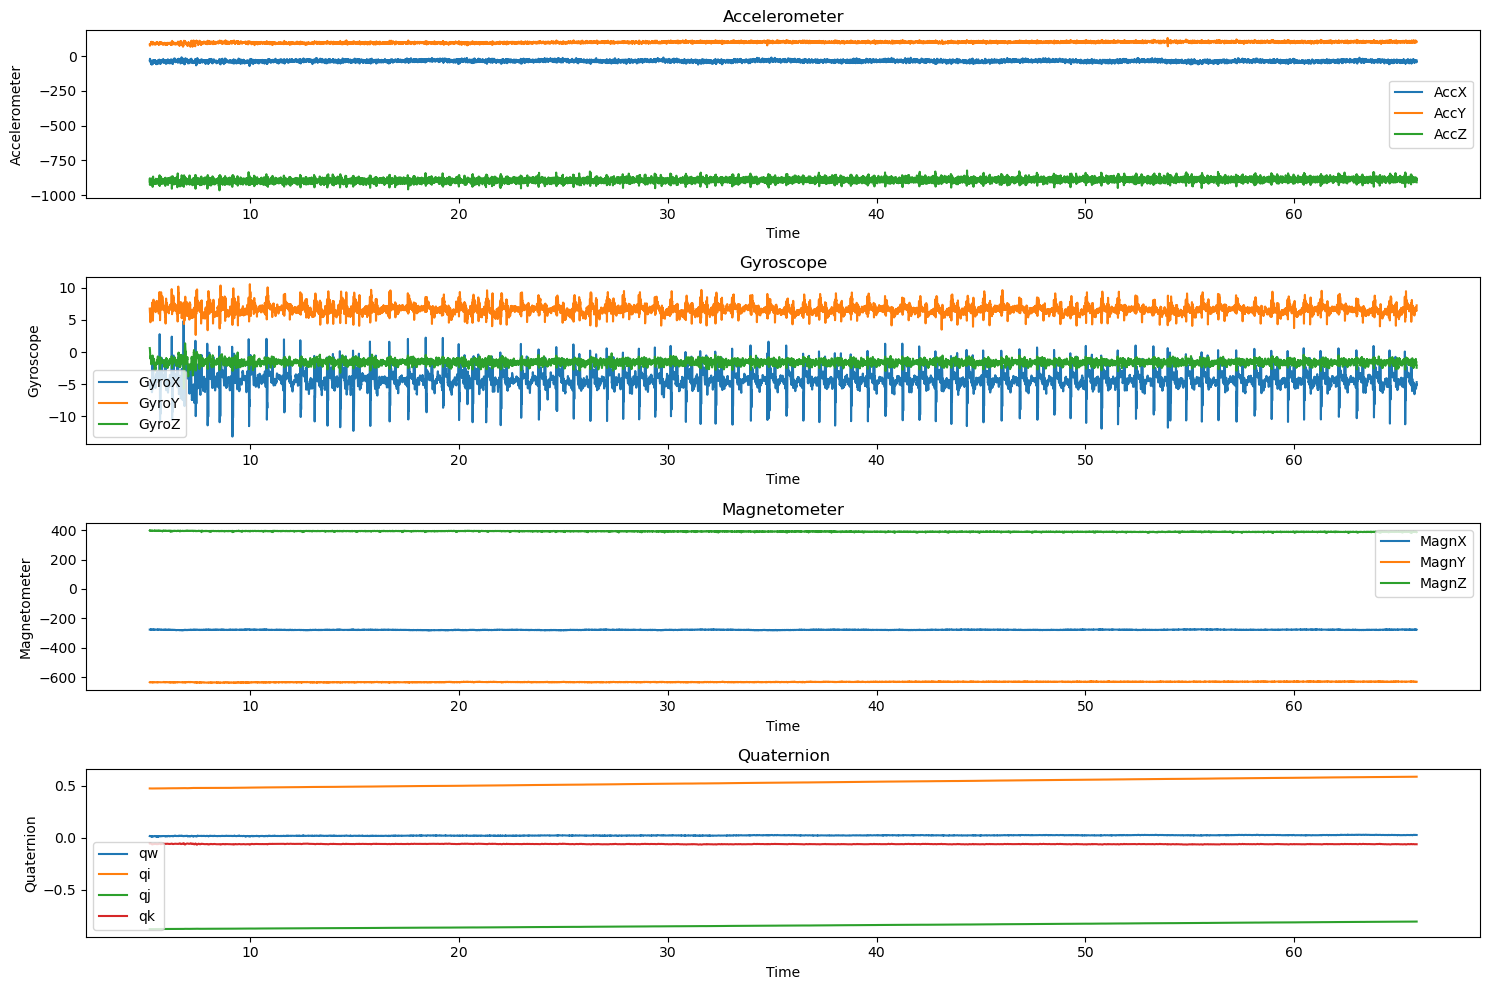

In [91]:
plot(cleaned_data, column_groups)


#### PCA

In [92]:
## Pre-processing data: dropping columns and scaling
data_for_pca = cleaned_data.drop(columns=["Log Freq","Log Mode", "Time", "Timestamp"])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_pca)

In [93]:
## Instantiating PCA and kernelPCA
pca = PCA()

## Computing PCA
data_after_pca = pca.fit_transform(scaled_data)

PCA tell us to keep 6 features to retain 90% variance


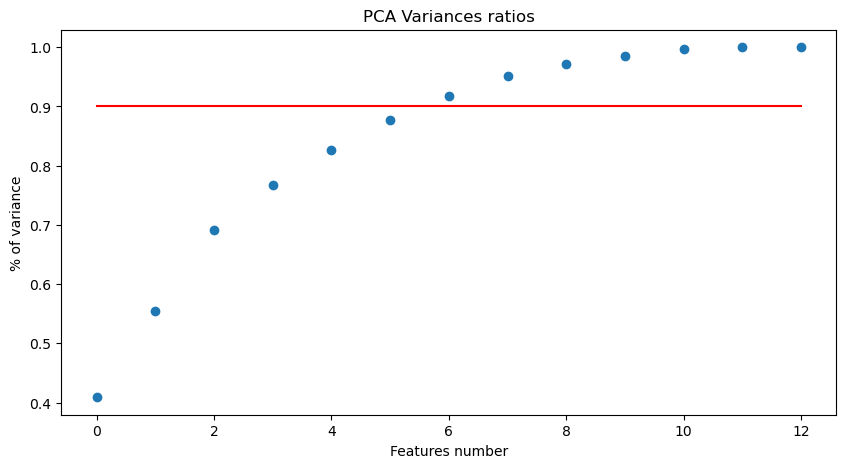

In [94]:
# Analyzing the result of PCA
PCA_Variances_Ratios = np.cumsum(pca.explained_variance_ratio_)

fig, ax1 = plt.subplots(1,1,figsize = (10,5))
ax1.scatter(np.arange(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
ax1.set_title("PCA Variances ratios")
ax1.set_ylabel("% of variance")
ax1.set_xlabel("Features number")
ax1.plot(np.arange(len(pca.explained_variance_ratio_)),np.ones(len(pca.explained_variance_ratio_))*0.9,color="red")
most_important_features_number = np.sum(np.cumsum(pca.explained_variance_ratio_) < 0.9)
print(f"PCA tell us to keep {most_important_features_number} features to retain 90% variance")

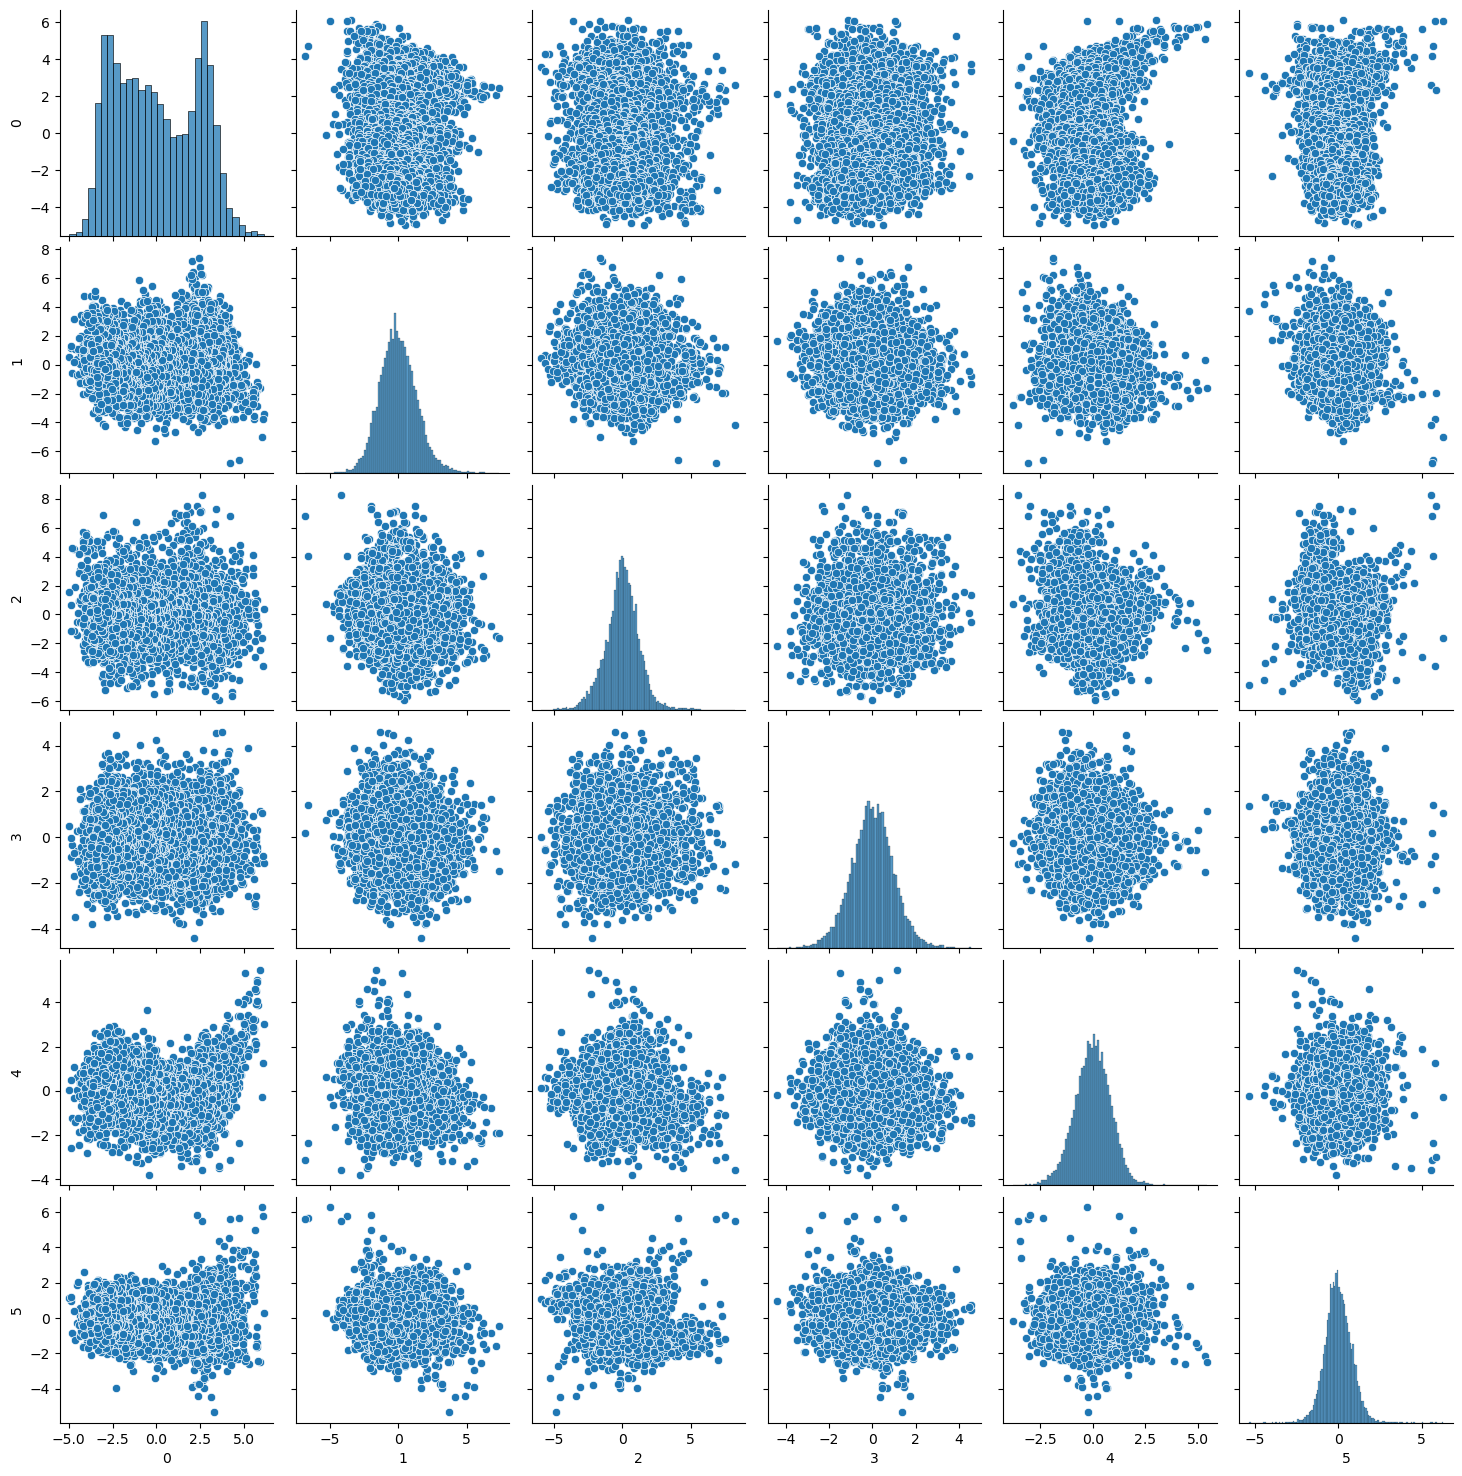

In [95]:
sns.pairplot(pd.DataFrame(data_after_pca[:,0:most_important_features_number]))

In [96]:
column_names = []
for i in range(1,14):
    column_names.append('Feature '+str(i))
data_after_pca_dataframe = pd.DataFrame(data_after_pca, columns=column_names)
description = data_after_pca_dataframe.describe()
description = description.append(pd.DataFrame(data_after_pca_dataframe.median(axis=0), columns=['median']).T)
description = description.append(pd.DataFrame(data_after_pca_dataframe.std(axis=0)**2, columns=['variance']).T)
print(description[column_names[0:5]])
print(description[column_names[5:10]])

AttributeError: 'DataFrame' object has no attribute 'append'

In [97]:
print(description[column_names[10:]])

         Feature 11    Feature 12    Feature 13
count  1.317700e+04  1.317700e+04  1.317700e+04
mean   4.745220e-17 -1.725534e-17  5.850640e-17
std    3.774943e-01  2.068066e-01  2.114878e-02
min   -1.519753e+00 -7.842762e-01 -5.750329e-02
25%   -2.520187e-01 -1.408134e-01 -1.561065e-02
50%   -7.542210e-03 -1.215857e-03 -3.066483e-03
75%    2.426634e-01  1.365879e-01  1.332914e-02
max    2.124735e+00  1.130415e+00  9.824407e-02


In [98]:
correlations = np.corrcoef(data_after_pca.T)
t = np.abs(correlations)*np.sqrt((len(data_after_pca_dataframe)-2)/(1-correlations**2))
for i in range(t.shape[0]):
    t[i,i]=0 
print(t[np.abs(t)>1e-3])

[]


/var/folders/59/2ssll6nn0s11xqwgwbgjf0wm0000gn/T/ipykernel_5560/2363383155.py:2: RuntimeWarning: divide by zero encountered in divide
  t = np.abs(correlations)*np.sqrt((len(data_after_pca_dataframe)-2)/(1-correlations**2))


The data after PCA is very uncorrelated.

In [99]:
"""
res = stats.normaltest(kpca_data, axis=0)
print(res.pvalue)
vaz = kpca_data[:,5]
plt.hist(vaz, bins=(1+np.int(np.ceil(np.log2(vaz.shape[0])))))
plt.ylim(0,2000)
def gaussian(x, mu, sig):
    return 9346*0.1/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
plt.plot(np.linspace(-1,1),gaussian(np.linspace(-1,1),1.349469e-16, 1.729172e-01))"""

'\nres = stats.normaltest(kpca_data, axis=0)\nprint(res.pvalue)\nvaz = kpca_data[:,5]\nplt.hist(vaz, bins=(1+np.int(np.ceil(np.log2(vaz.shape[0])))))\nplt.ylim(0,2000)\ndef gaussian(x, mu, sig):\n    return 9346*0.1/(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)\nplt.plot(np.linspace(-1,1),gaussian(np.linspace(-1,1),1.349469e-16, 1.729172e-01))'

#### FAST FOURIER TRANSFORM

In [100]:
data_after_pca_only_most_important_feature = data_after_pca[:,0:most_important_features_number]
N = len(data_after_pca)

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_after_pca_only_most_important_feature, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/mean_frequency))

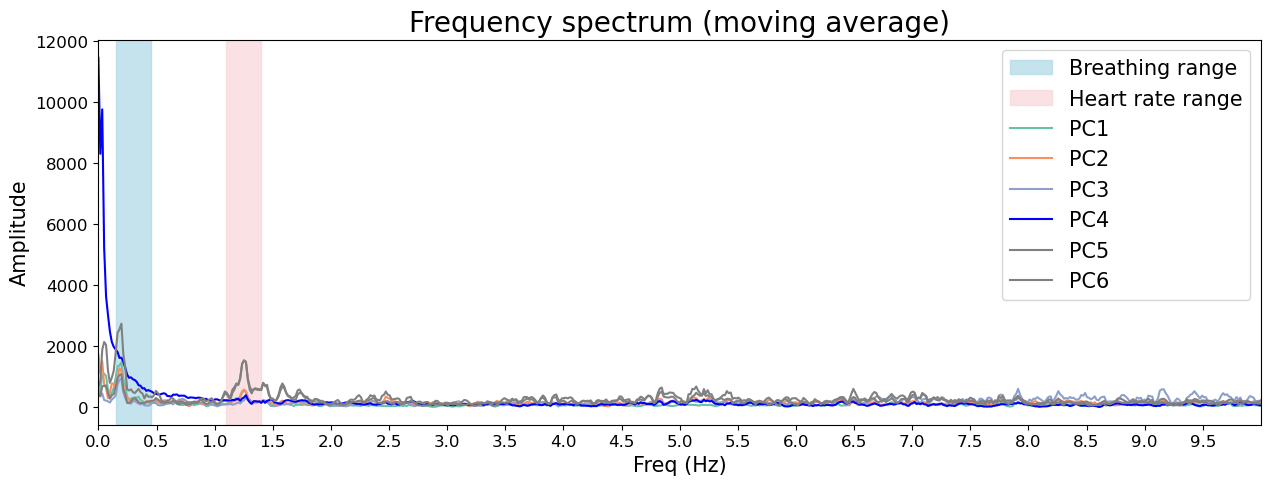

In [102]:
# Find the minima of the spectrum of the fourth principal component
minima, _ = signal.find_peaks(-np.abs(sig_fft[N//2:, 1]))


# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))

ax.axvspan(0.15, 0.45, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heart rate range")

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(0, 10)
ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=15)
#ax.grid('lightgrey')


Text(0.5, 1.0, 'Heartbeat Frequency spectrum')

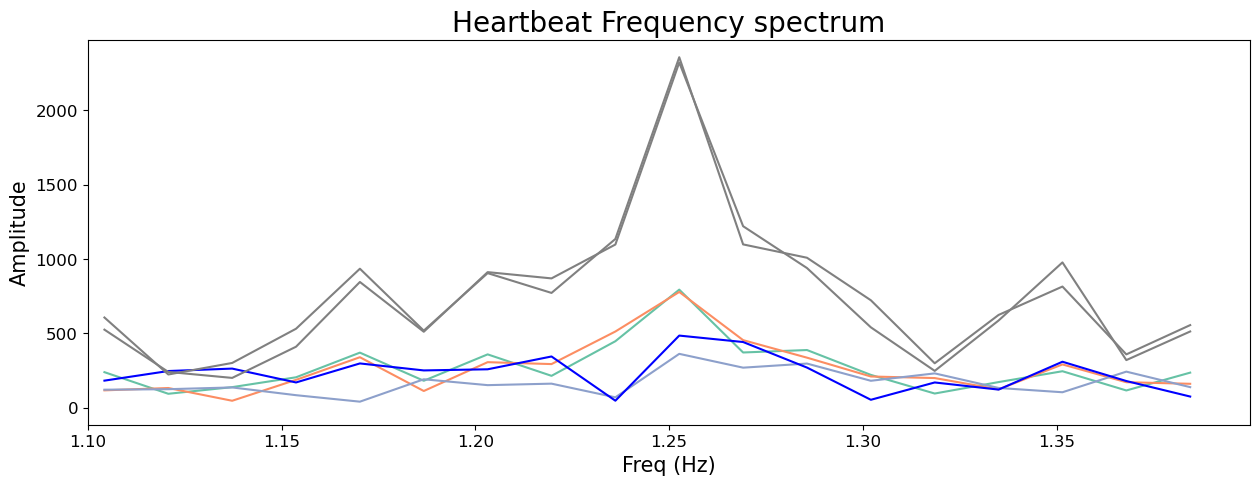

In [103]:
# Plot relevant frequency band
fig, ax = plt.subplots(figsize=(15, 5))

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[np.logical_and(frequencies > 1.1, frequencies < 1.4)], np.abs(sig_fft[np.logical_and(frequencies > 1.1, frequencies < 1.4), i]), 3, color=color, label="PC"+str(i+1))

ax.set_xlim(1.1, 1.4)
ax.xaxis.set_ticks(np.arange(1.1, 1.4, 0.05))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Heartbeat Frequency spectrum", fontsize=20)
#ax.grid('lightgrey')

# Filter

In [104]:
sig_fft[np.logical_or(frequencies < 1.1, frequencies > 1.4)] = 0

inversed_sig_fft = np.fft.ifft(np.fft.ifftshift(sig_fft), axis=0)

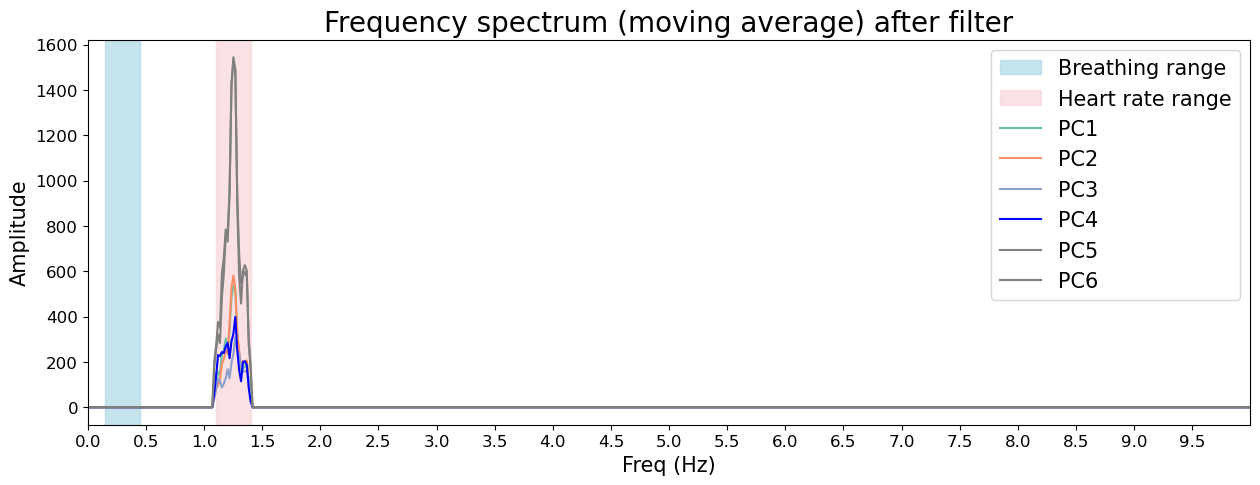

In [105]:
# Find the minima of the spectrum of the fourth principal component
minima, _ = signal.find_peaks(-np.abs(sig_fft[N//2:, 3]))


# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))

ax.axvspan(0.15, 0.45, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heart rate range")

pca_indeces = np.arange(most_important_features_number)
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue', 'grey', 'grey']
palette = palette[0:most_important_features_number]
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(0, 10)
ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average) after filter", fontsize=20)
ax.legend(fontsize=15)
#ax.grid('lightgrey')

Text(0.5, 0, 'Time')

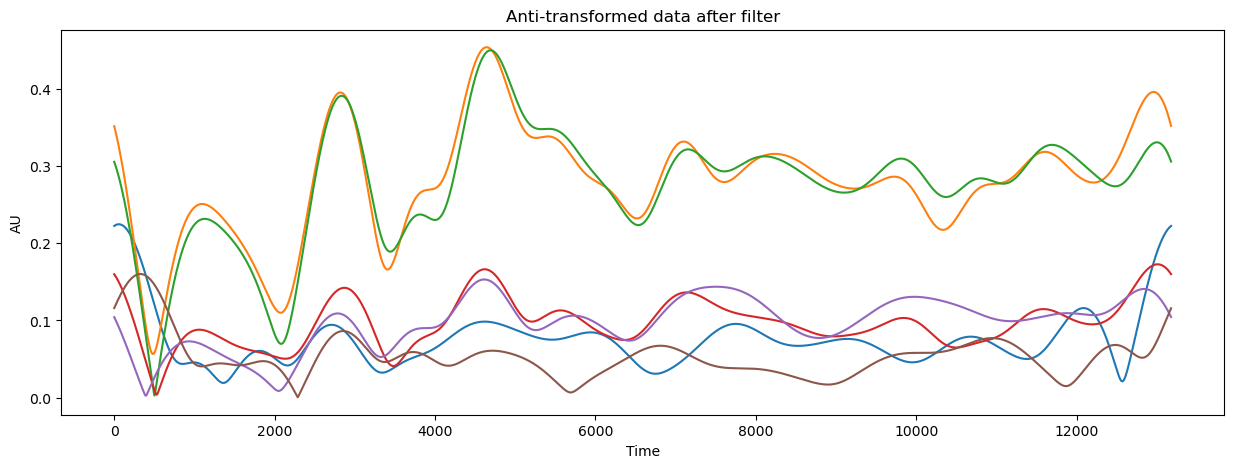

In [106]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.abs(inversed_sig_fft))
ax.set_title("Anti-transformed data after filter")
ax.set_ylabel("AU")
ax.set_xlabel("Time")